### Trying to cluster

In [1]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

In [72]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

In [2]:
rsfMRI_info = pd.read_excel("data/TiMeS_rsfMRI_info.xlsx", engine="openpyxl")  
regression_info = pd.read_excel("data/TiMeS_regression_info_processed.xlsx", engine="openpyxl")
rsfMRI_full_info = pd.read_excel("data/TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")
print(regression_info.columns)
print(rsfMRI_info)
regression_info=regression_info[['Stroke_location', 'Lesion_side', 'lesion_volume_mm3']]

Index(['subject_full_id', 'TimePoint', 'Behavioral_assessment', 'MRI',
       'Gender', 'Age', 'Education_level', 'Lesion_side_old', 'Lesion_side',
       'Combined', 'Bilateral', 'Comments', 'Stroke_location',
       'lesion_volume_mm3', 'NIHSS', 'FAB_abstraction', 'FAB_flexibility',
       'FAB_programmation', 'FAB_sensitivity_to_interference',
       'FAB_inhibitory_control', 'FAB_environmental_autonomy', 'FAB_TOT',
       'Stroop_color_time', 'Stroop_color_error', 'Stroop_words_time',
       'Stroop_words_error', 'Stroop_interference_time',
       'Stroop_interference_error', 'Stroop_index_WC', 'Stroop_index_InC',
       'Digit_forward_SPAN', 'Digit_forward_TOTAL', 'Digit_backward_SPAN',
       'Digit_backward_TOTAL', 'Digit_sequencing_SPAN',
       'Digit_sequencing_TOTAL', 'Digit_TOTAL',
       'Fugl_Meyer_right_UPPER_EXTREMITY', 'Fugl_Meyer_right_WRIST',
       'Fugl_Meyer_right_HAND', 'Fugl_Meyer_right_COORDINATION_SPEED',
       'Fugl_Meyer_right_TOTAL', 'Fugl_Meyer_left_UPPER

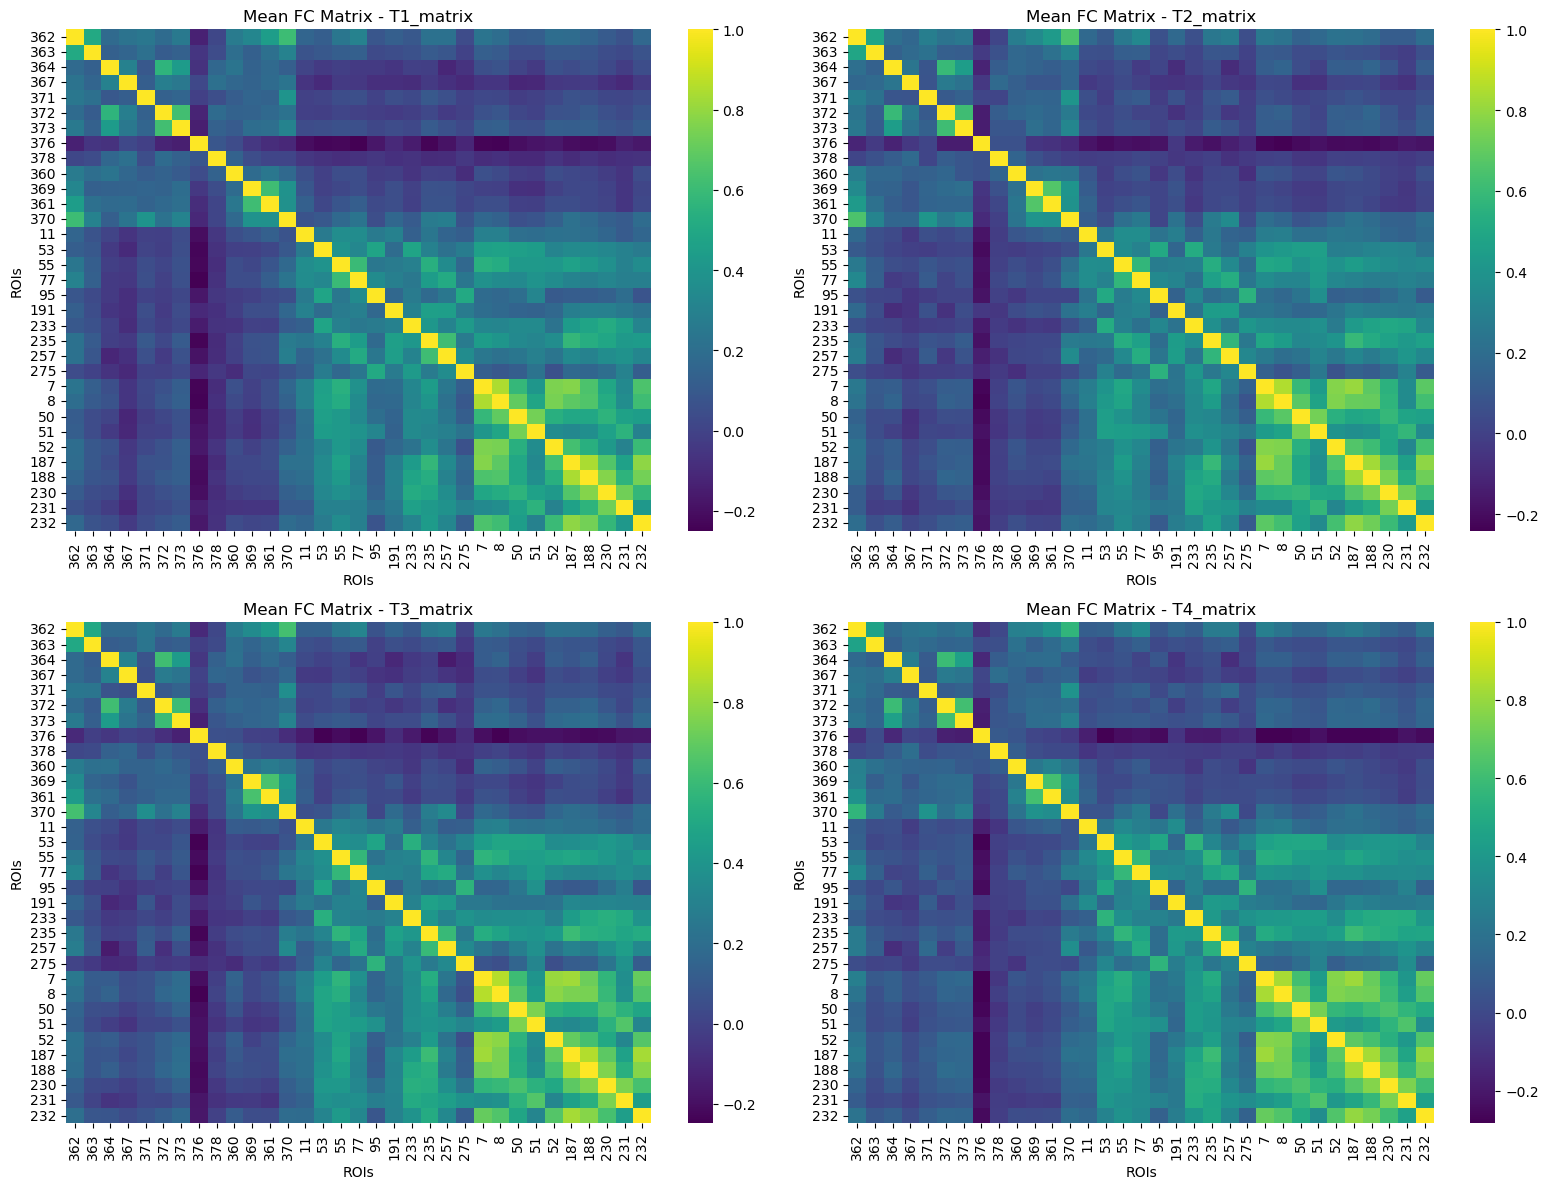

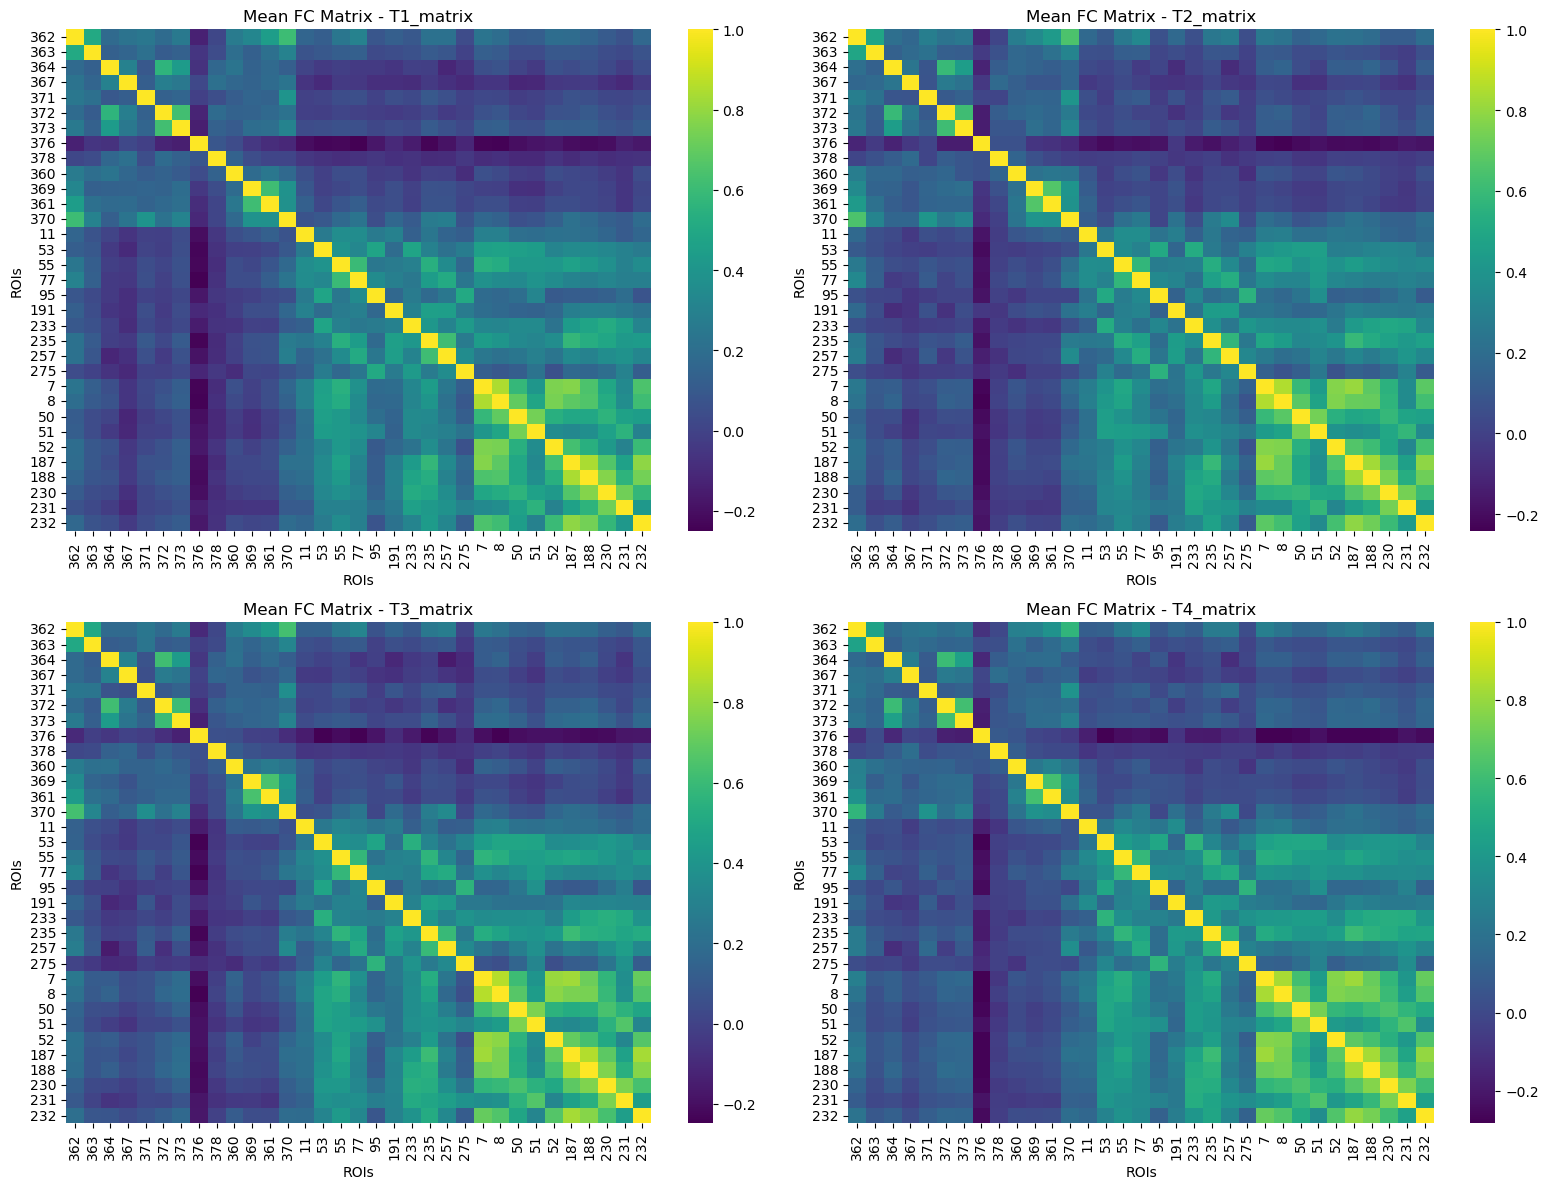

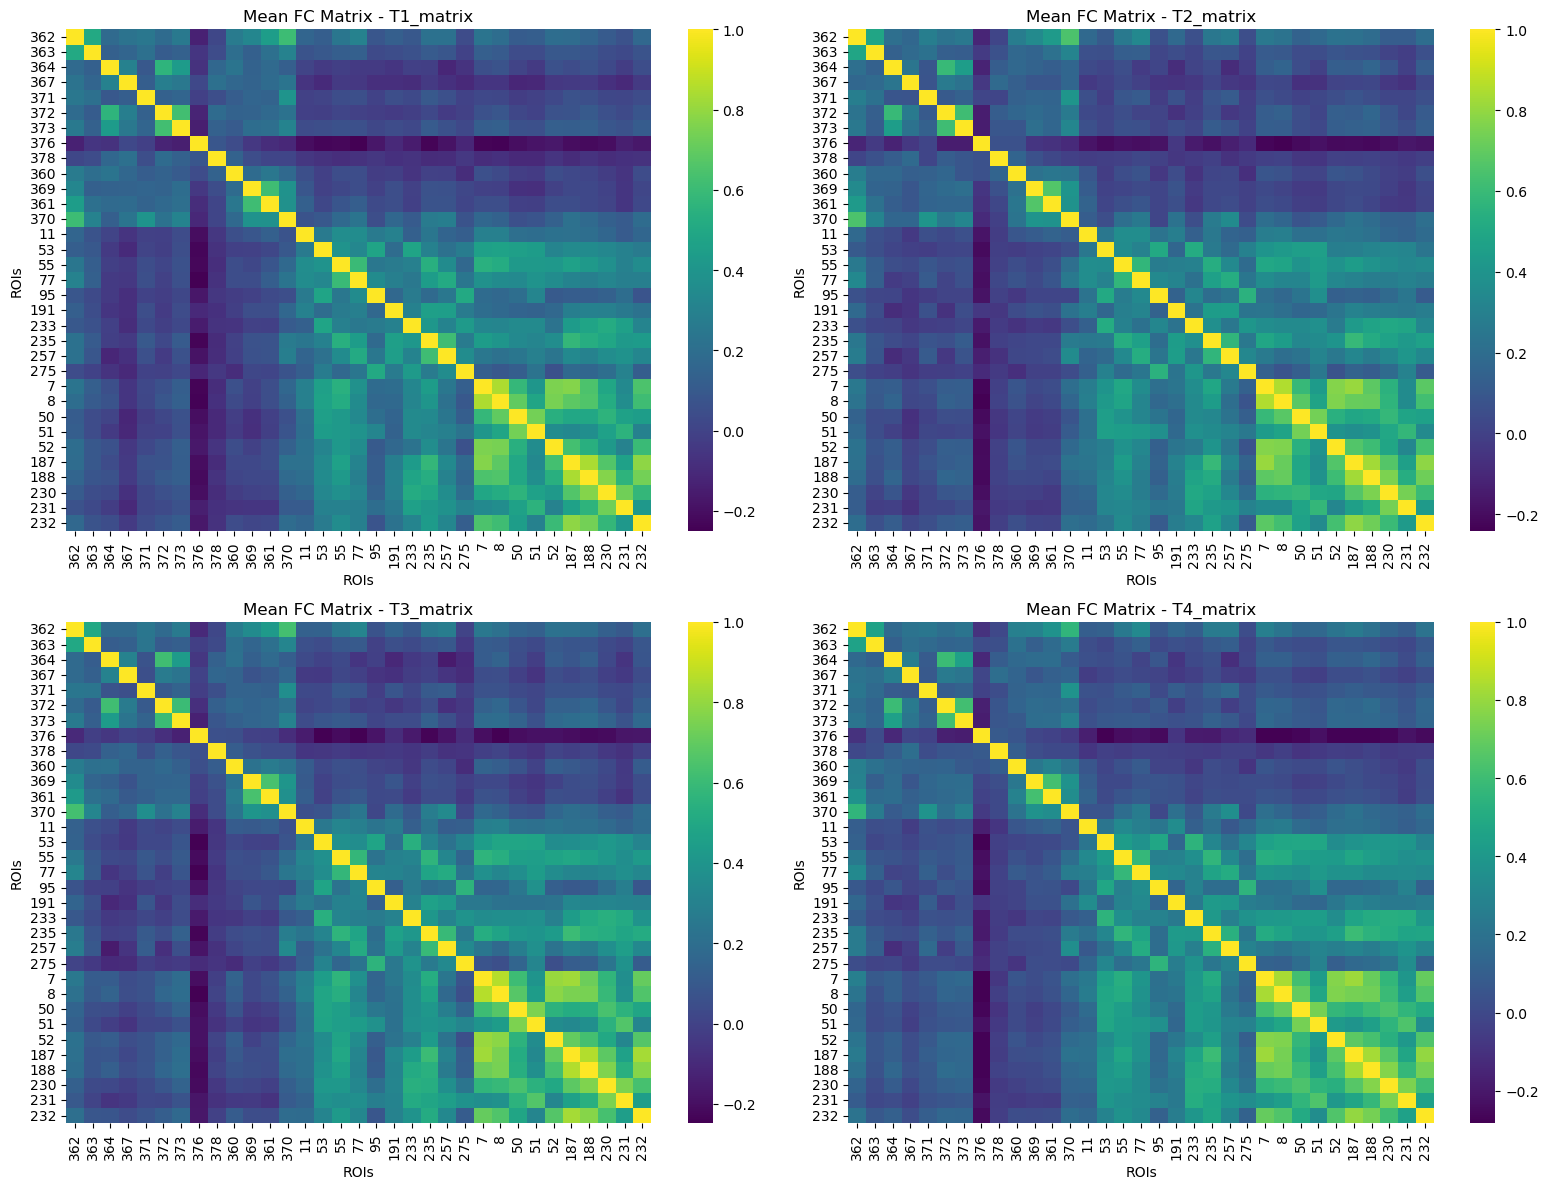

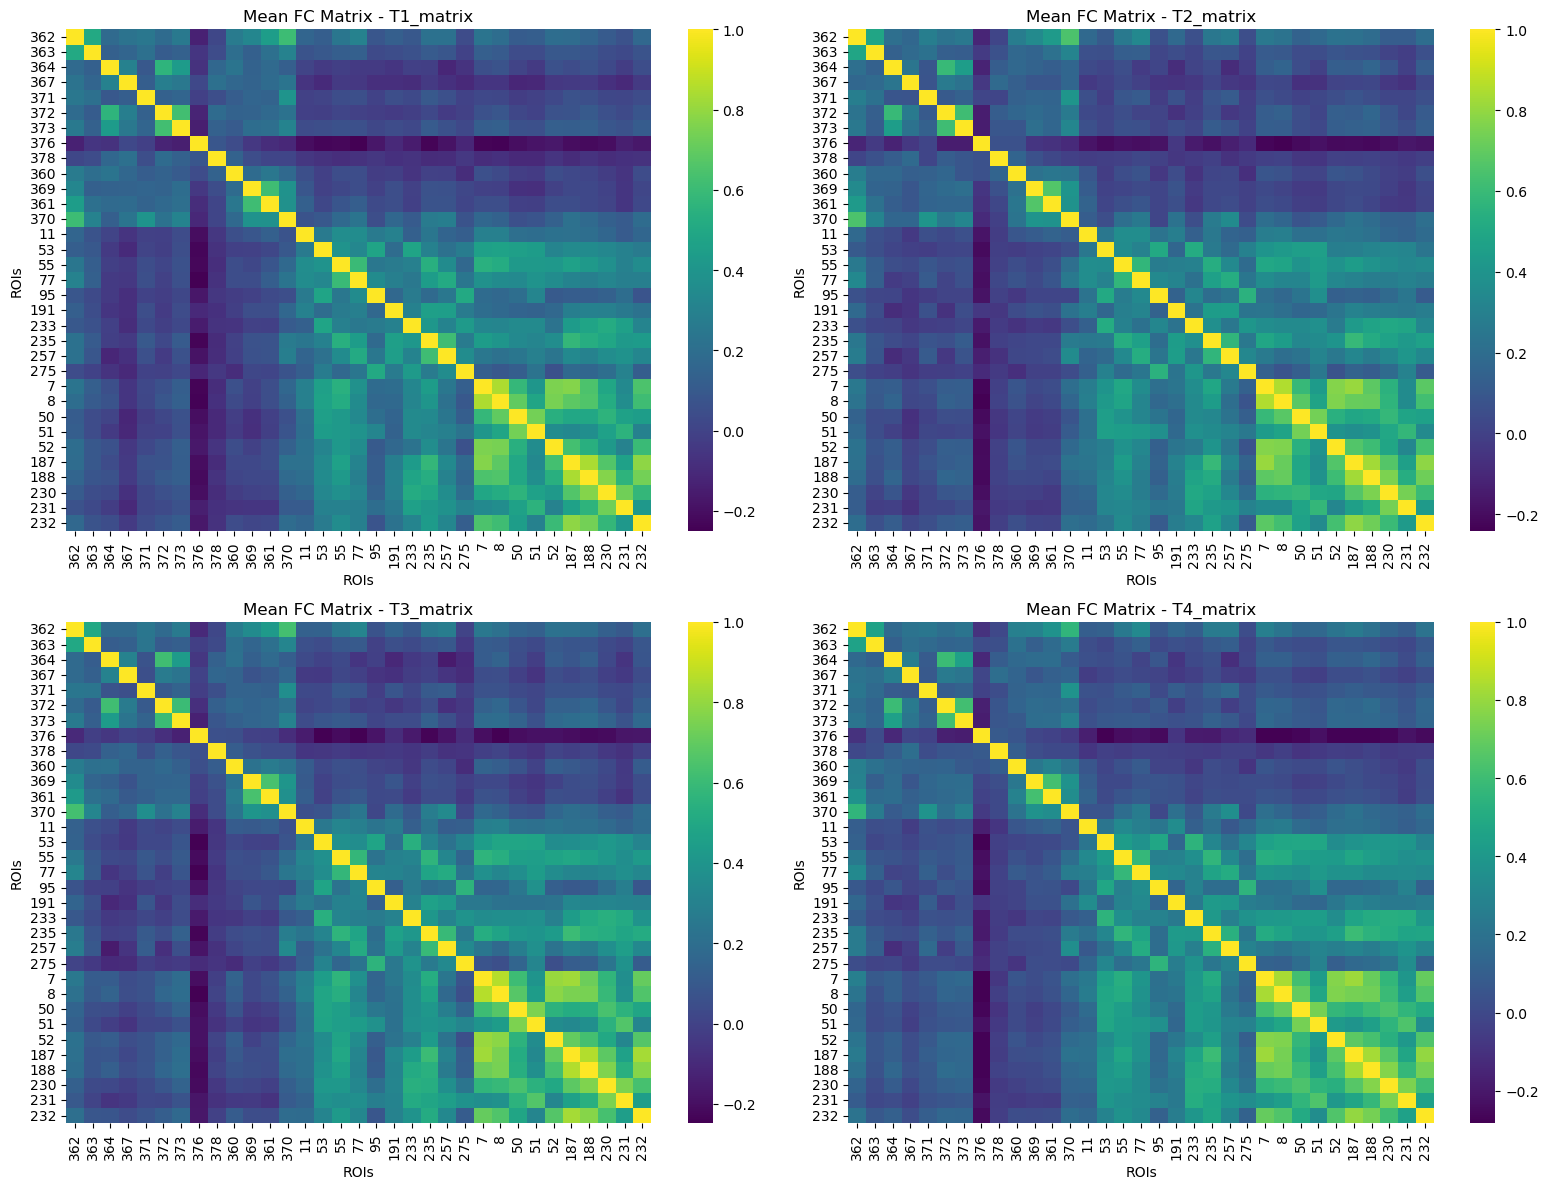

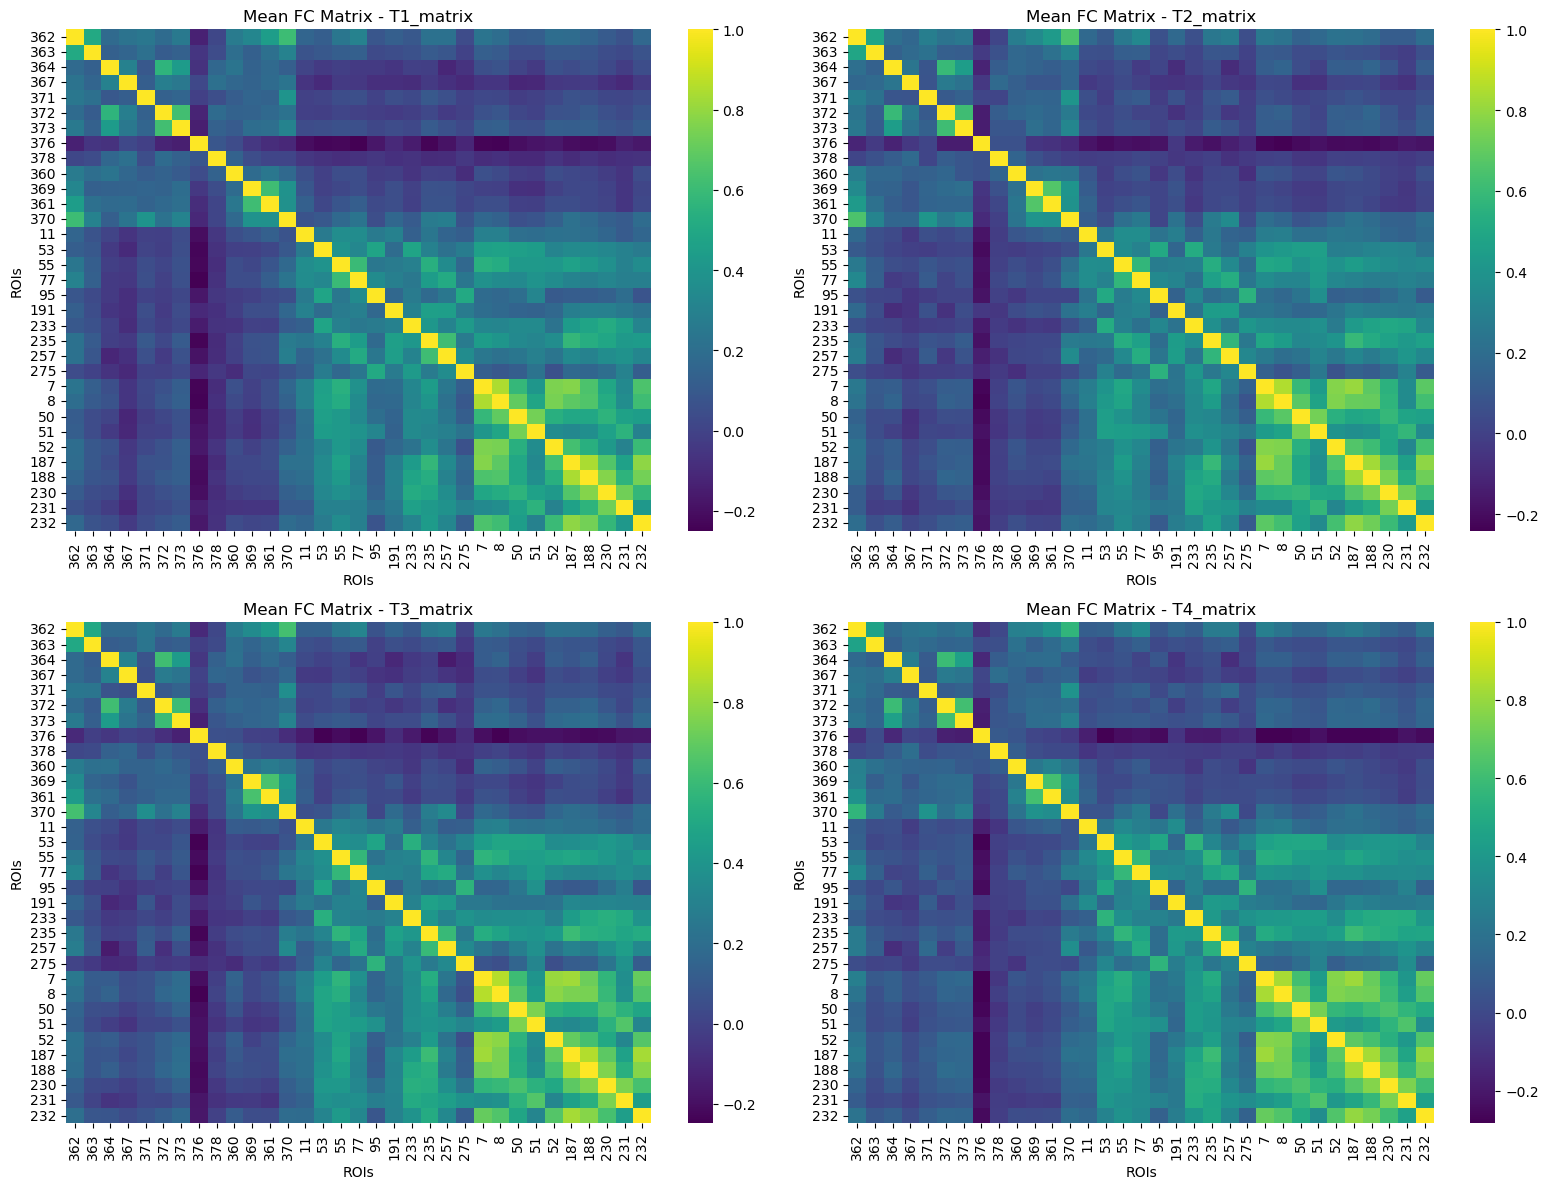

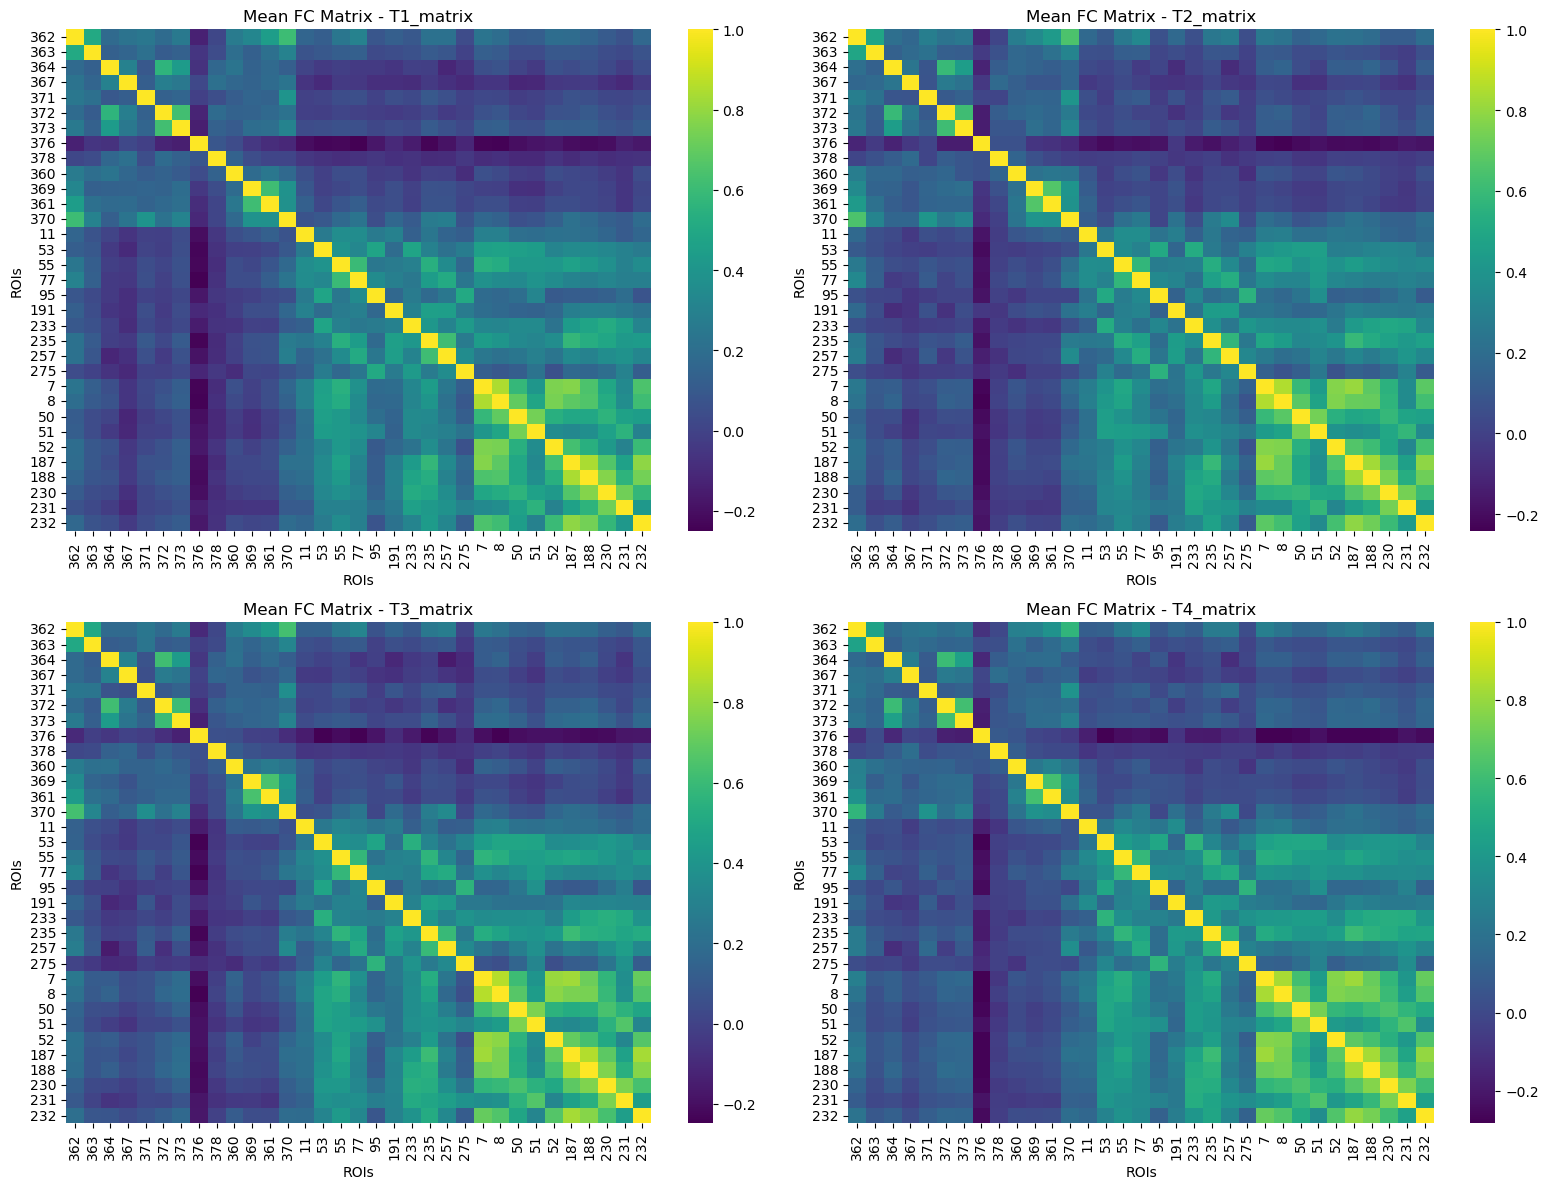

In [ ]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, regression_info, rsfMRI_full_info, t1_subjects = functions.load_data(folder_path, rois, type='t1_only')
all_matrices, regression_info, rsfMRI_full_info, all_subjects = functions.load_data(folder_path, rois, type='all')
t1_t3_matched, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3_matched')
t1_t4_matched, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4_matched')
t1_t3_matrices, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3')
t1_t4_matrices, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4')
#matrices = functions.matrices_to_wide_df(matrices)
all_matrices

Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [8]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'subject_full_id',
       'Lesion_side', 'Stroke_location', 'lesion_volume_mm3', 'Gender', 'Age',
       'Education_level', 'Combined', 'Bilateral'],
      dtype='object')


##### Cluster for all matrices

In [9]:
categorical_cols = ['Lesion_side', 'Stroke_location','Education_level','Combined', 'Bilateral']
numerical_cols = ['lesion_volume_mm3','Age','Gender']

all_matrices_labeled = functions.cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
#t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
#t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)

# NORMAL THAT WE GET THE SAME CLUSTERS FOR ALL TIMEPOINTS
# because we are using the same data for clustering (T1)

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')
Silhouette score: 0.021924092422265305
Cluster 0: ['s063', 's015', 's082', 's021']
Cluster 1: ['s007', 's031', 's054', 's008', 's037', 's030', 's039', 's006', 's055', 's052', 's046', 's070', 's048', 's083', 's049', 's076', 's078', 's047', 's040', 's014', 's013', 's025', 's022'

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')


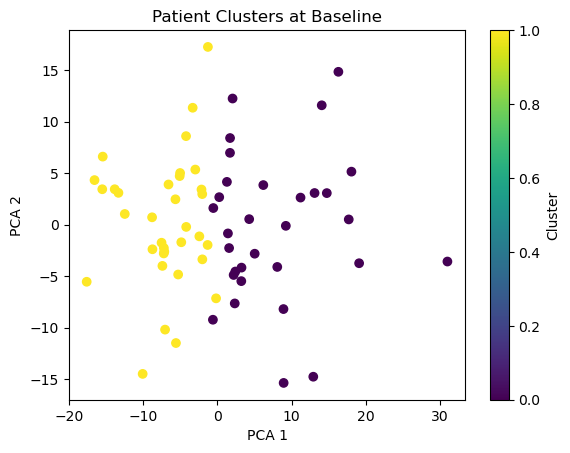

Silhouette score: 0.07799938839454668
Cluster 0: ['s062', 's065', 's001', 's052', 's063', 's083', 's012', 's015', 's082', 's071', 's047', 's014', 's013', 's025', 's022', 's059', 's068', 's050', 's003', 's060', 's033', 's002', 's029', 's045', 's042', 's080', 's073', 's017', 's021', 's086', 's081']
Cluster 1: ['s007', 's031', 's009', 's036', 's054', 's008', 's037', 's030', 's039', 's006', 's055', 's041', 's046', 's070', 's048', 's049', 's076', 's078', 's040', 's066', 's057', 's004', 's032', 's051', 's067', 's005', 's027', 's020', 's016', 's011', 's074', 's019', 's072', 's075']


In [10]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)

#### Version Chat payant:

Flattening FC matrices on 65 subjects...
[INFO] Missing numerical values detected. Imputing with column means...
Applying PCA...
Testing different cluster numbers...


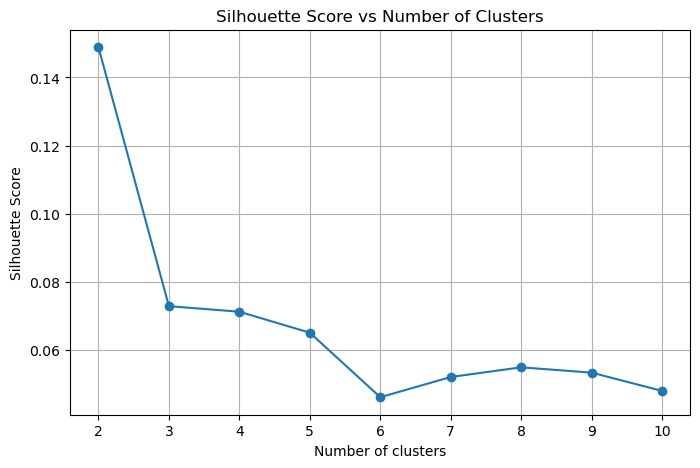

Best number of clusters according to silhouette score: 2


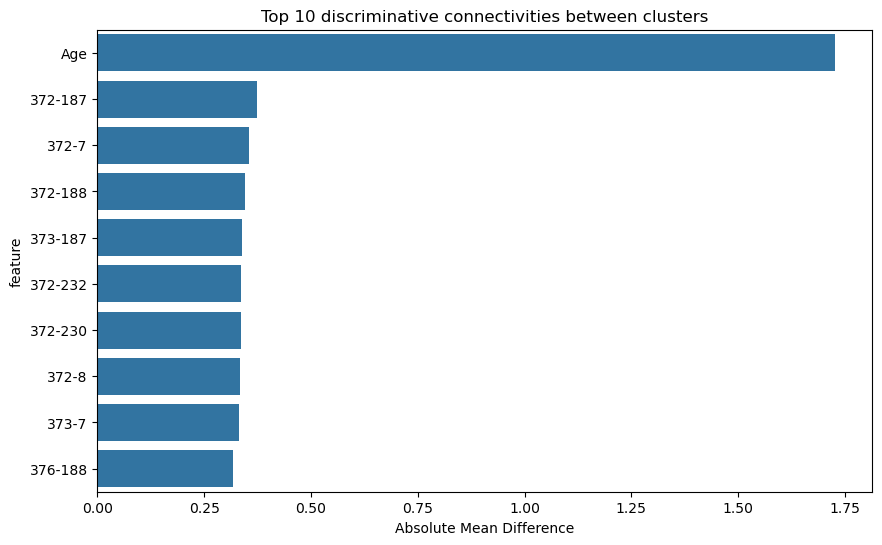

In [14]:
selected_rois_labels = [362, 363, 364, 367, 371, 372, 373, 376] 

t1_t3_matrices_labeled, clusters, silhouette_scores, pca_features, scaler, pca, all_features, feature_names = functions.cluster_subjects(
    t1_t3_matrices, 
    selected_rois_labels, 
    matrix_column='T1_matrix', 
    numerical_cols=numerical_cols, 
    categorical_cols=categorical_cols
)

importance_df = functions.compute_feature_importance(all_features, clusters, feature_names)

Flattening FC matrices on 65 subjects...
[INFO] Missing numerical values detected. Imputing with column means...
Applying PCA...
Testing different cluster numbers...


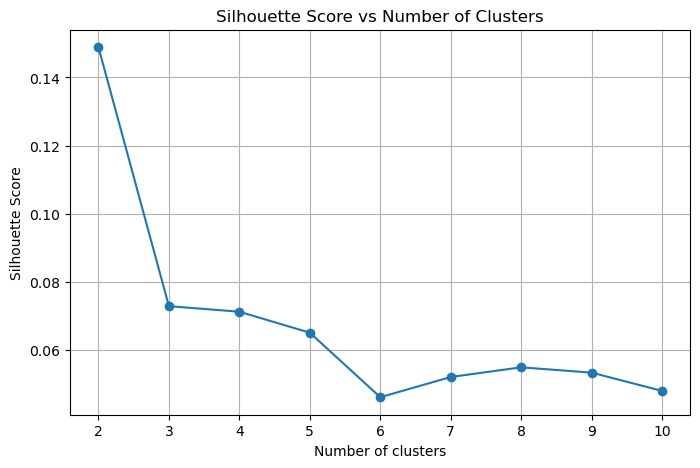

Best number of clusters according to silhouette score: 2


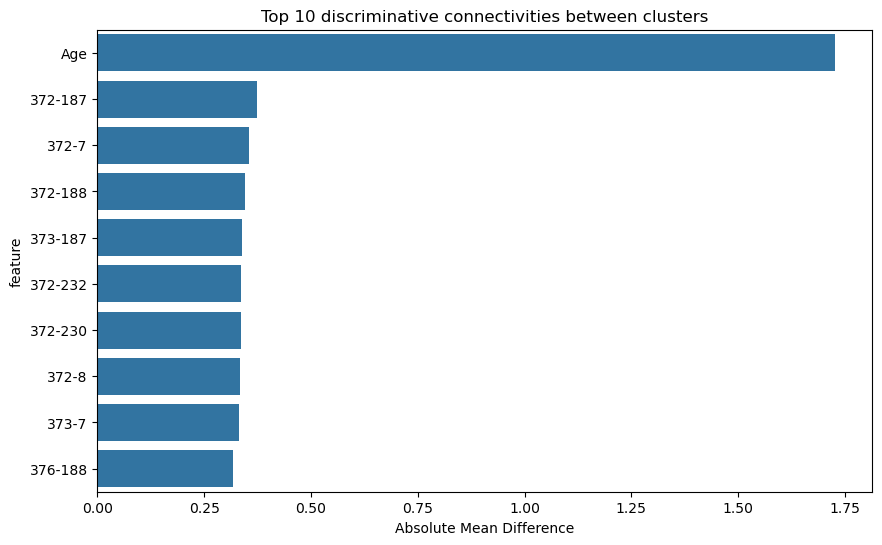

In [17]:
t1_t4_matrices_labeled, clusters, silhouette_scores, pca_features, scaler, pca, all_features, feature_names = functions.cluster_subjects(
    t1_t4_matrices, 
    selected_rois_labels, 
    matrix_column='T1_matrix', 
    numerical_cols=numerical_cols, 
    categorical_cols=categorical_cols
)

importance_df = functions.compute_feature_importance(all_features, clusters, feature_names)

### Beginning of statistical testing


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (13, 33, 33)
Cluster 0 - Shape of T3 matrices: (13, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 33.93it/s]


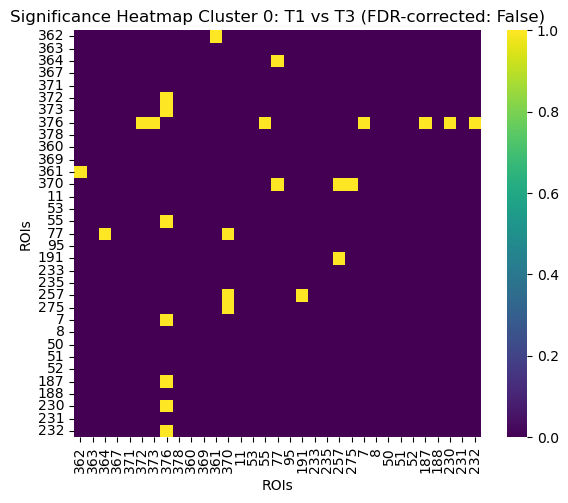


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (26, 33, 33)
Cluster 1 - Shape of T3 matrices: (26, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.45it/s]


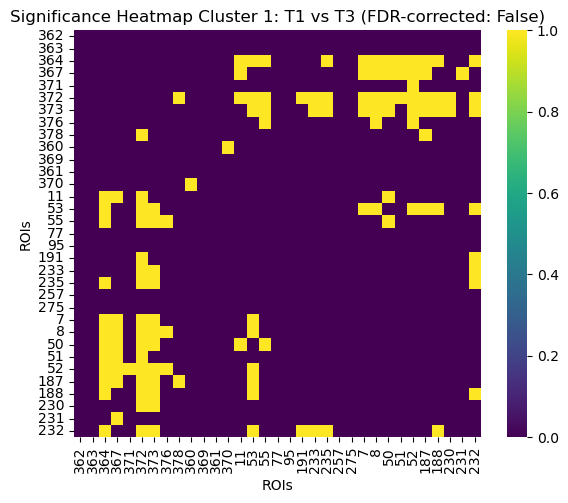

In [18]:
results = functions.get_sig_matrix(t1_t3_matrices_labeled, rois, correction=False, alpha=0.05, cluster=True)


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (13, 33, 33)
Cluster 0 - Shape of T3 matrices: (13, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 36.74it/s]


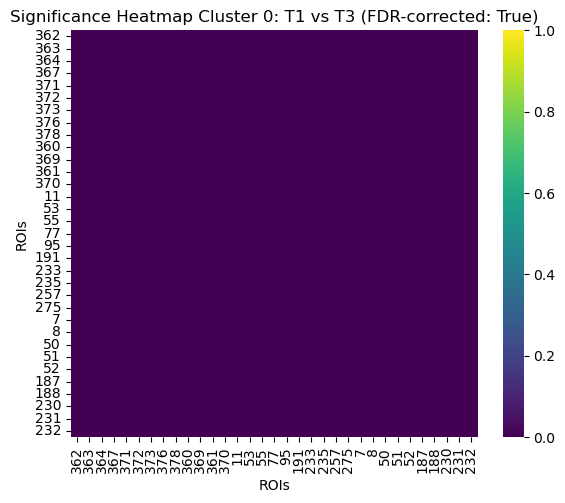


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (26, 33, 33)
Cluster 1 - Shape of T3 matrices: (26, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 36.61it/s]


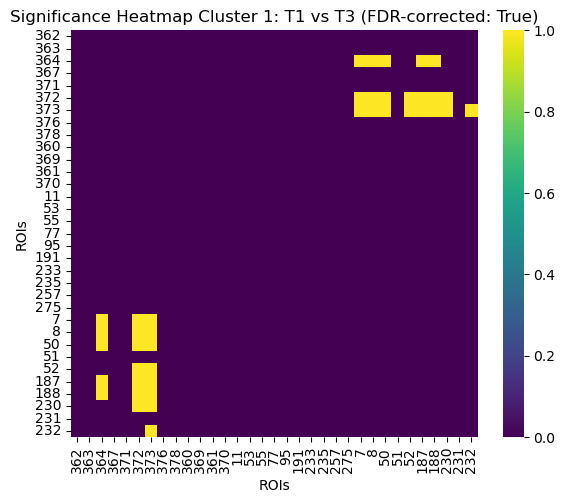

In [21]:
results = functions.get_sig_matrix(t1_t3_matrices_labeled, rois, correction=True, alpha=0.05, cluster=True)


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (12, 33, 33)
Cluster 0 - Shape of T4 matrices: (12, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.33it/s]


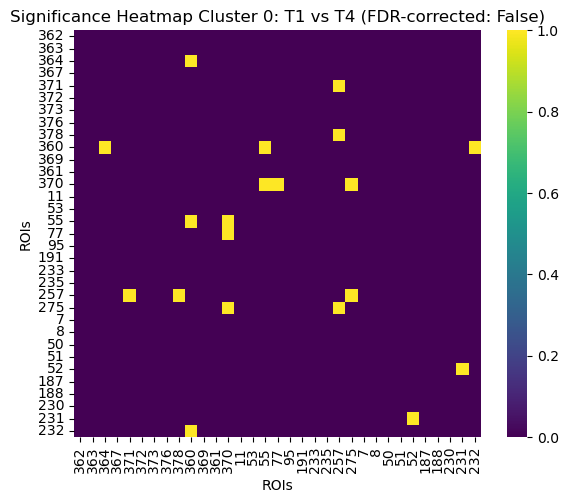


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (24, 33, 33)
Cluster 1 - Shape of T4 matrices: (24, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 33.96it/s]


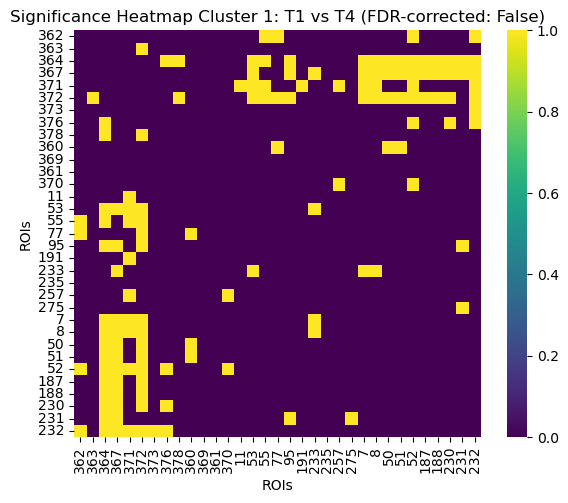

In [24]:
results = functions.get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=False, alpha=0.05, cluster=True)

Shape of T1 matrices: (65, 33, 33)
Shape of T3 matrices: (44, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:01<00:00, 31.91it/s]


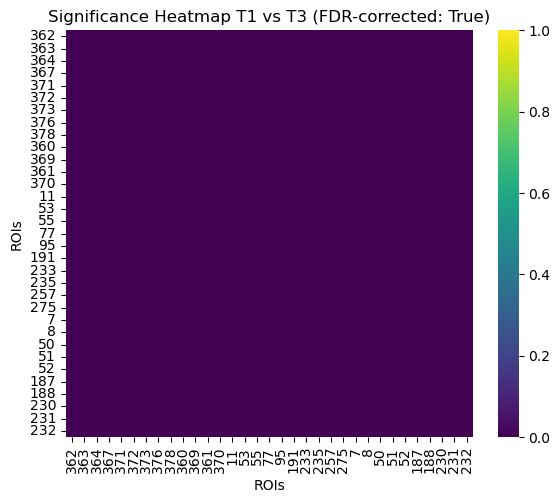

Shape of T1 matrices: (65, 33, 33)
Shape of T3 matrices: (44, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 35.00it/s]


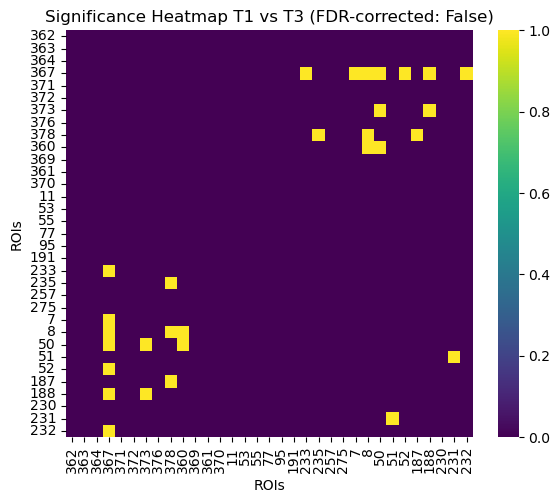


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (12, 33, 33)
Cluster 0 - Shape of T4 matrices: (12, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 35.98it/s]


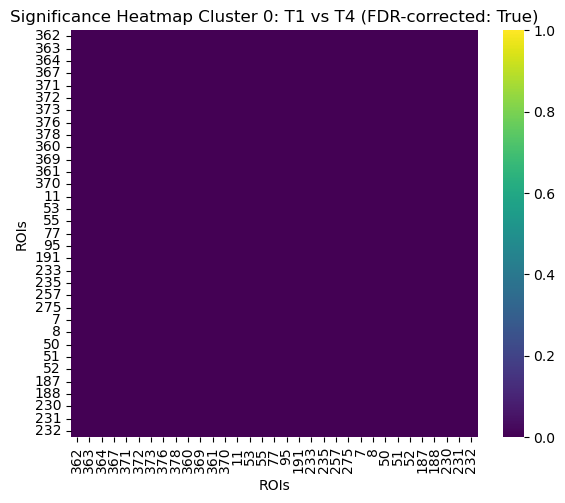


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (24, 33, 33)
Cluster 1 - Shape of T4 matrices: (24, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.51it/s]


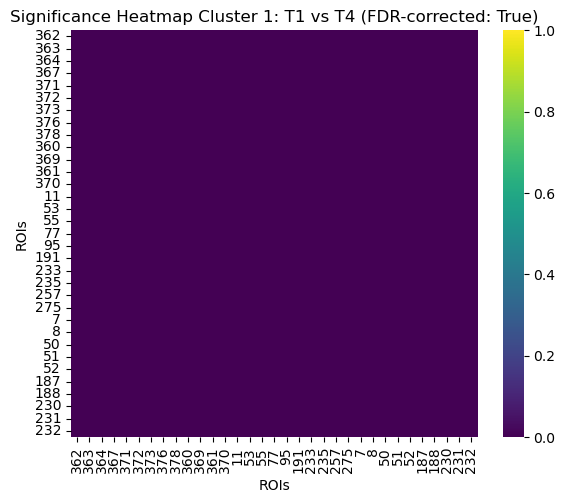


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (12, 33, 33)
Cluster 0 - Shape of T4 matrices: (12, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.43it/s]


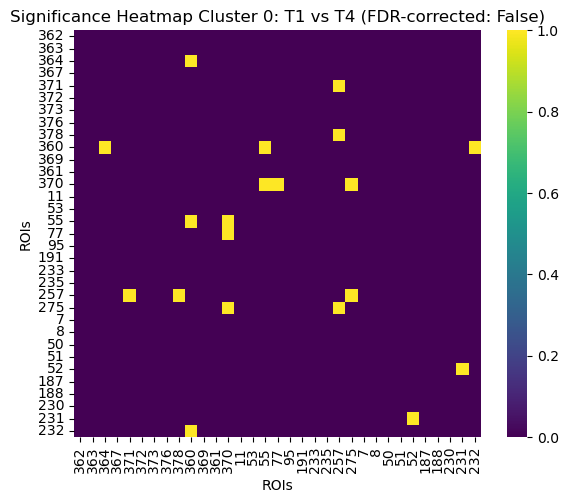


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (24, 33, 33)
Cluster 1 - Shape of T4 matrices: (24, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:01<00:00, 32.00it/s]


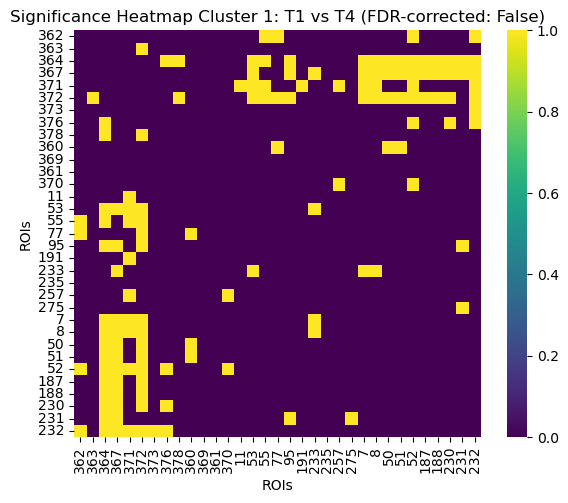

Shape of T1 matrices: (65, 33, 33)
Shape of T4 matrices: (42, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:01<00:00, 31.89it/s]


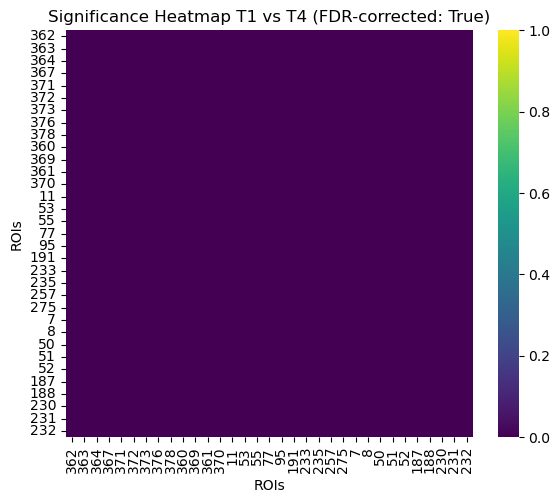

Shape of T1 matrices: (65, 33, 33)
Shape of T4 matrices: (42, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 33.07it/s]


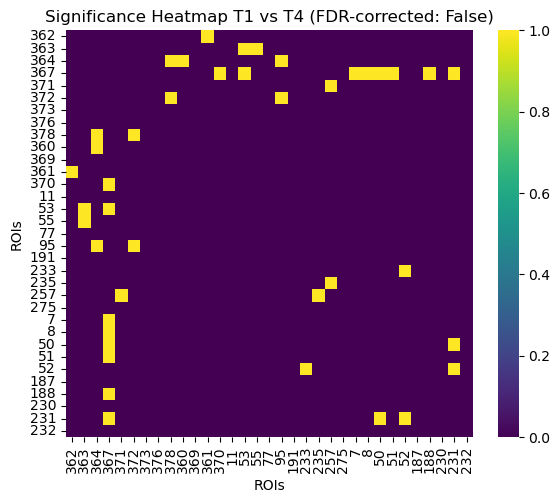

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[       nan, 0.25551029, 0.4015783 , ..., 0.64122593, 0.62244395,
         0.34159699],
        [0.25551029,        nan, 0.52060866, ..., 0.34481731, 0.26292186,
         0.87332444],
        [0.4015783 , 0.52060866,        nan, ..., 0.16426855, 0.37499409,
         0.09500018],
        ...,
        [0.64122593, 0.34481731, 0.16426855, ...,        nan, 0.55472845,
         0.6415112 ],
        [0.62244395, 0.26292186, 0.37499409, ..., 0.55472845,        nan,
         0.50564467],
        [0.34159699, 0.87332444, 0.09500018, ..., 0.6415112 , 0.50564467,
                nan]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [Fal

In [25]:
functions.get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=True, alpha=0.05, cluster=False)
functions.get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=False, alpha=0.05, cluster=False)
functions.get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=True, alpha=0.05, cluster=True)
functions.get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=False, alpha=0.05, cluster=True)
functions.get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=True, alpha=0.05, cluster=False)
functions.get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=False, alpha=0.05, cluster=False)

#### Code to do it by cluster for both T3 and T4

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')


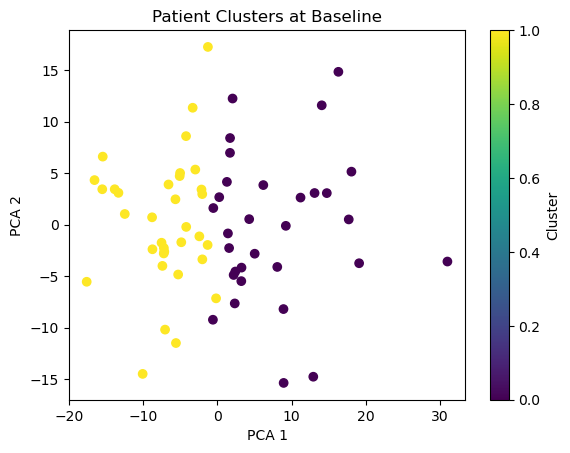

Silhouette score: 0.07799938839454668
Cluster 0: ['s062', 's065', 's001', 's052', 's063', 's083', 's012', 's015', 's082', 's071', 's047', 's014', 's013', 's025', 's022', 's059', 's068', 's050', 's003', 's060', 's033', 's002', 's029', 's045', 's042', 's080', 's073', 's017', 's021', 's086', 's081']
Cluster 1: ['s007', 's031', 's009', 's036', 's054', 's008', 's037', 's030', 's039', 's006', 's055', 's041', 's046', 's070', 's048', 's049', 's076', 's078', 's040', 's066', 's057', 's004', 's032', 's051', 's067', 's005', 's027', 's020', 's016', 's011', 's074', 's019', 's072', 's075']


AttributeError: module 'functions' has no attribute 'compare_T1_T_by_cluster'

In [ ]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)
functions.compare_T1_T_by_cluster(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True) # A RENDRE POSSIBLE

### Look at difference between FC

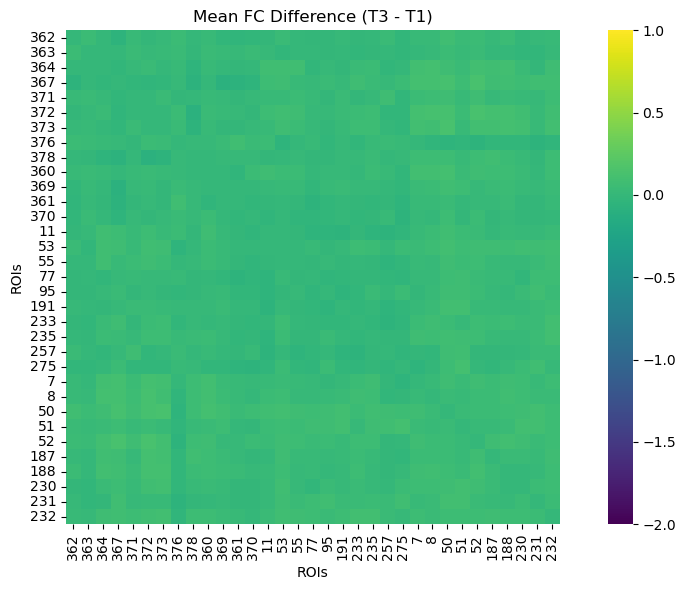

In [35]:
t1_t3_matched_diff = functions.compute_FC_diff(t1_t3_matched, rois, tp = 3)

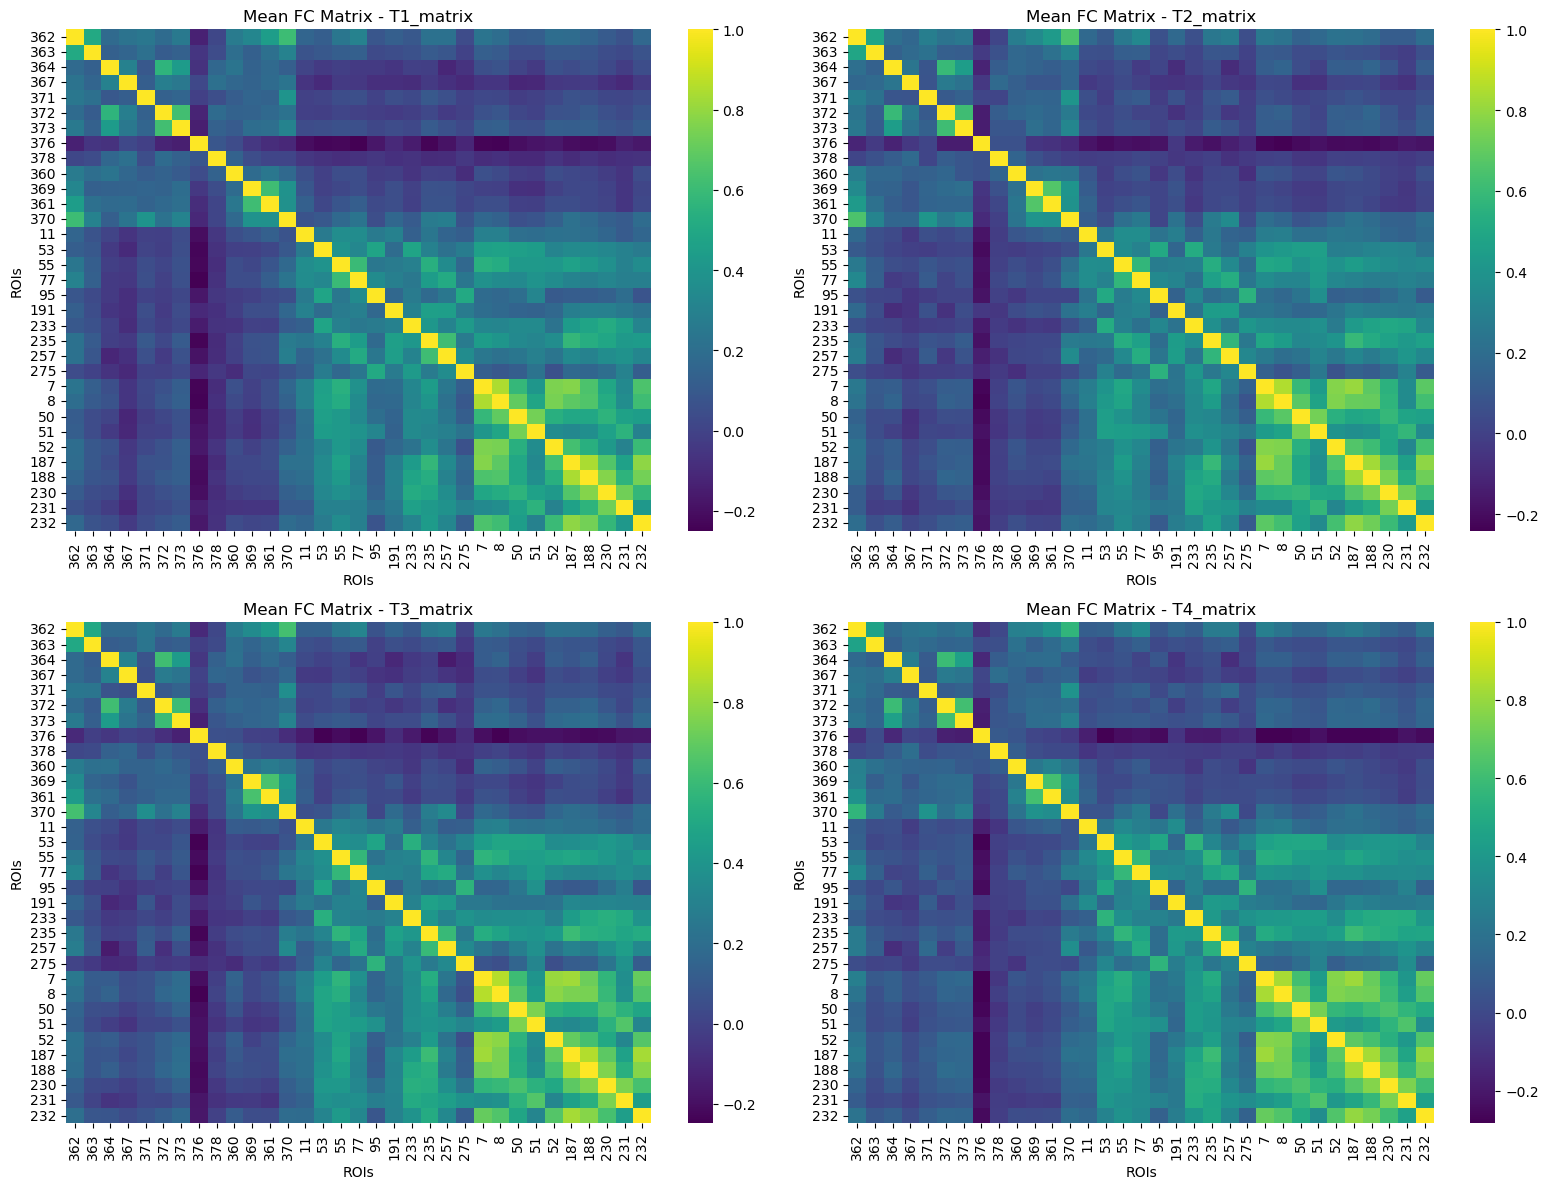

In [36]:
functions.plot_mean_FC_matrices(all_matrices, rois)

### Regression Analysis

In [42]:
functions.test_normality(regression_info)

                               Variable         W       p-value  \
0                     lesion_volume_mm3  0.662422  1.387019e-25   
1                                 NIHSS  0.599826  1.894083e-27   
2                       FAB_abstraction  0.330186  1.608263e-33   
3                       FAB_flexibility  0.765989  8.369961e-22   
4                     FAB_programmation  0.526658  2.335800e-29   
5       FAB_sensitivity_to_interference  0.379692  1.418530e-32   
6                FAB_inhibitory_control  0.583891  6.911108e-28   
7            FAB_environmental_autonomy  0.122960  5.953099e-37   
8                               FAB_TOT  0.777710  2.673758e-21   
9                     Stroop_color_time  0.485765  2.520191e-30   
10                   Stroop_color_error  0.269896  1.343274e-34   
11                    Stroop_words_time  0.591968  1.147657e-27   
12                   Stroop_words_error  0.280795  2.077752e-34   
13             Stroop_interference_time  0.767888  1.007287e-2

,Variable,W,p-value,Normal? (p > 0.05)
0,lesion_volume_mm3,0.662422,1.387019e-25,False
1,NIHSS,0.599826,1.894083e-27,False
2,FAB_abstraction,0.330186,1.608263e-33,False
3,FAB_flexibility,0.765989,8.369961e-22,False
4,FAB_programmation,0.526658,2.335800e-29,False
5,FAB_sensitivity_to_interference,0.379692,1.418530e-32,False
6,FAB_inhibitory_control,0.583891,6.911108e-28,False
7,FAB_environmental_autonomy,0.122960,5.953099e-37,False
8,FAB_TOT,0.777710,2.673758e-21,False
9,Stroop_color_time,0.485765,2.520191e-30,False


only SMN_intra_unaff_FC is normal !

now I will look at wilcoxon score for different timepoints

In [52]:
from scipy.stats import wilcoxon

score_T1 = regression_info[regression_info.TimePoint == "T1"].iloc[:, 14:] # de "TimePoint"=="T1"
score_T1 = score_T1.dropna()
score_T3 = regression_info[regression_info.TimePoint == "T3"].iloc[:, 14:] # de "TimePoint"=="T2"
score_T3 = score_T3.dropna()

# check that the two groups are matched, so keep only the subjects that are in both groups
#common_ids = set(score_T1['subject_full_id']).intersection(score_T3['subject_full_id'])
#score_T1_matched = score_T1[score_T1['subject_full_id'].isin(common_ids)].copy()
#score_T3_matched = score_T3[score_T3['subject_full_id'].isin(common_ids)].copy()

stat, p = wilcoxon(score_T1, score_T3, axis = 0)  # Paired sample
print("Wilcoxon test p-values: ", p)

Wilcoxon test p-values:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


In [73]:
results = functions.motor_longitudinal(regression_info)
results

,Task,n,p-value,Statistically sig. change between TP
0,FAB_abstraction,47,8.510499e-01,No
1,FAB_flexibility,47,4.677735e-03,Yes
2,FAB_programmation,47,1.322356e-02,Yes
3,FAB_sensitivity_to_interference,47,4.673636e-03,Yes
4,FAB_inhibitory_control,47,2.177073e-03,Yes
5,FAB_environmental_autonomy,47,8.326452e-02,No
6,FAB_TOT,47,5.472044e-05,Yes
7,Stroop_color_time,47,3.593277e-02,Yes
8,Stroop_color_error,47,2.905775e-01,No
9,Stroop_words_time,47,4.887531e-02,Yes


subject_full_id: p = nan
FAB_abstraction: p = nan
FAB_flexibility: p = nan
FAB_programmation: p = nan
FAB_sensitivity_to_interference: p = nan
FAB_inhibitory_control: p = nan
FAB_environmental_autonomy: p = nan
FAB_TOT: p = nan
Stroop_color_time: p = nan
Stroop_color_error: p = nan
Stroop_words_time: p = nan
Stroop_words_error: p = nan
Stroop_interference_time: p = nan
Stroop_interference_error: p = nan
Stroop_index_WC: p = nan
Stroop_index_InC: p = nan
Digit_forward_SPAN: p = nan
Digit_forward_TOTAL: p = nan
Digit_backward_SPAN: p = nan
Digit_backward_TOTAL: p = nan
Digit_sequencing_SPAN: p = nan
Digit_sequencing_TOTAL: p = nan
Digit_TOTAL: p = nan
Fugl_Meyer_right_UPPER_EXTREMITY: p = nan
Fugl_Meyer_right_WRIST: p = nan
Fugl_Meyer_right_HAND: p = nan
Fugl_Meyer_right_COORDINATION_SPEED: p = nan
Fugl_Meyer_right_TOTAL: p = nan
Fugl_Meyer_left_UPPER_EXTREMITY: p = nan
Fugl_Meyer_left_WRIST: p = nan
Fugl_Meyer_left_HAND: p = nan
Fugl_Meyer_left_COORDINATION_SPEED: p = nan
Fugl_Meyer_lef